In [3]:
%load_ext autoreload
%autoreload 2

In [48]:
#importamos librerias
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
from scipy.signal import find_peaks
# Paquete de modelos de neuronas
from neuron_models.utils import *
# Importamos los modelos
from neuron_models.adex import Adex_model, test_adex
from neuron_models.lif import LIF_model, test_lif
from neuron_models.hodgkin_huxley import test_hyh
import ipywidgets as widgets

## Introducción: 

En el presente trabajo se desarrollaron modelos mecanicistas de neuronas en python como clases con los métodos necesarios para fijar parámetros, simular y ajustar a una medicion minimizando las tasas de disparo. Se desarrollaron 3 modelos que intentan representar la actividad neuronal, el primero el famoso modelo de Hodgkin y Huxley (HyH), luego el modelo de Leaky Integrate and Fire (LIF) y por último Adaptive Exponential Integrate and Fire ( AdEx). Una vez desarrollados los modelos se probaron sus respuestas frente a distintos estímulos y en que casos un modelo representaba mejor que otro. Por último, se pusieron a prueba los modelos LIF y AdEx en una competencia organizada por “Collaborative Research in Computational Neuroscience” o CRCNS por sus siglas.


# Competencia CRNCS 2009:

Como ya mencionamos en la introducción, esta fue una competencia de neurociencia computacional donde a partir de datos reales de corriente inyectada y tensión medida de una neurona se nos pide que mediante la aplicación de modelos de neuronas lleguemos a predecir la respuesta de la neurona frente a la corriente. El dataset consta de dos archivos “current.txt” y “voltage_allrep.txt”. El primero contenía la corriente inyectada en la neurona, la misma corriente tenía dos fases: una inicial de entrenamiento que constaba de 4 pulsos cuadrados y otra de testeo en forma de ruido.

Los datos utilizados forman parte de una competencia de neuroscience CRNCS 2009, para mas informacion acerca del ejercicio la consigna se encuentra en el siguiente link https://crcns.org/files/data/ch-epfl-2009/crcns-ch-epfl-2009-instructions.pdf. En nuestro caso nosotros desarollaremos el ejercicio A del mismo, que consiste en entrenar un modelo de célula única a mediciones reales.


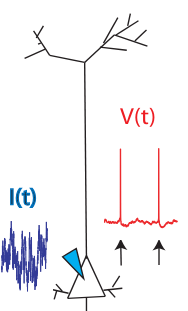



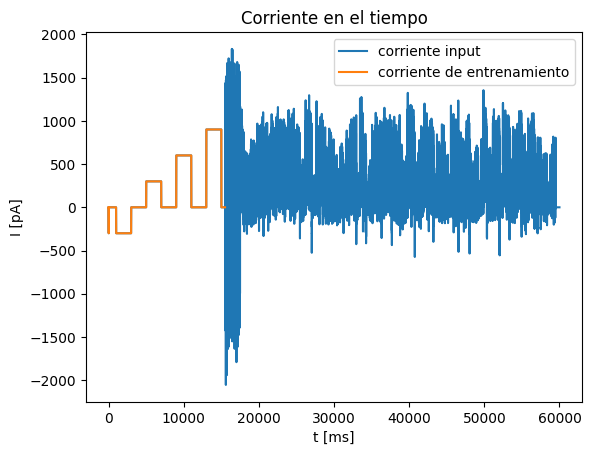

In [5]:
#lectura de archivos
# Leemos la corriente
corrientes = r"dataset/current.txt"
data = np.loadtxt(corrientes, delimiter=',')
I_data= np.loadtxt(corrientes, delimiter=',')*pA

t_max = 60*1e3*ms
train_end_t = 155000
fs = len(I_data-1)/t_max
t_total = np.arange(0, t_max, 1/fs)
t = t_total[:train_end_t]
I_train = I_data[:train_end_t]
I_test = I_data[train_end_t:]

plt.plot(t_total/ms, I_data/pA, label='corriente input')
plt.plot(t/ms, I_train/pA, label='corriente de entrenamiento')
plt.xlabel('t [ms]')
plt.ylabel('I [pA]')
plt.title('Corriente en el tiempo')
plt.legend()
plt.show()

 Por otro lado se nos daba información sobre el comportamiento inicial de la neurona en “volatage_allrep.txt”. Este archivo contiene 12 repeticiones del experimento aunque solo de la etapa inicial de “entrenamiento” del modelo la cual constaba de los primeros 16 segundos de 60 del experimento. Se llevó a cabo la apertura y lectura de ambos datasets y con la ayuda de la función find_peaks de la librería scipy.signal se logró identificar los tiempos de disparos de neuronas para luego utilizarlos para el ajuste del modelo.


In [6]:
# Leemos las mediciones de voltaje
path = r"dataset/voltage_allrep.txt"
headers = [f"rep{i+1}" for i in range(12)]
v_data = pd.read_csv(path, delimiter="  ", header=None, names=headers, index_col=False)
v_train = v_data["rep1"][:train_end_t]
v_test = v_data["rep1"][train_end_t:]

C:\Users\Juan Bautista\AppData\Local\Temp\ipykernel_6528\2949970621.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  v_data = pd.read_csv(path, delimiter="  ", header=None, names=headers, index_col=False)
C:\Users\Juan Bautista\AppData\Local\Temp\ipykernel_6528\2949970621.py:4: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  v_data = pd.read_csv(path, delimiter="  ", header=None, names=headers, index_col=False)


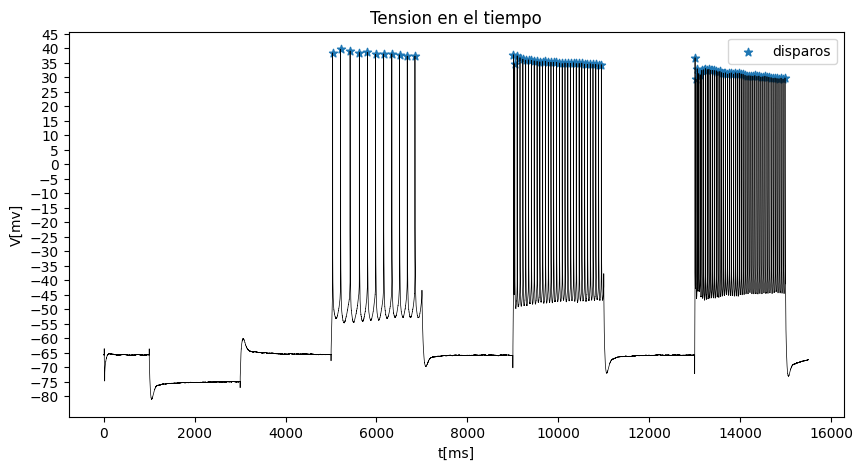

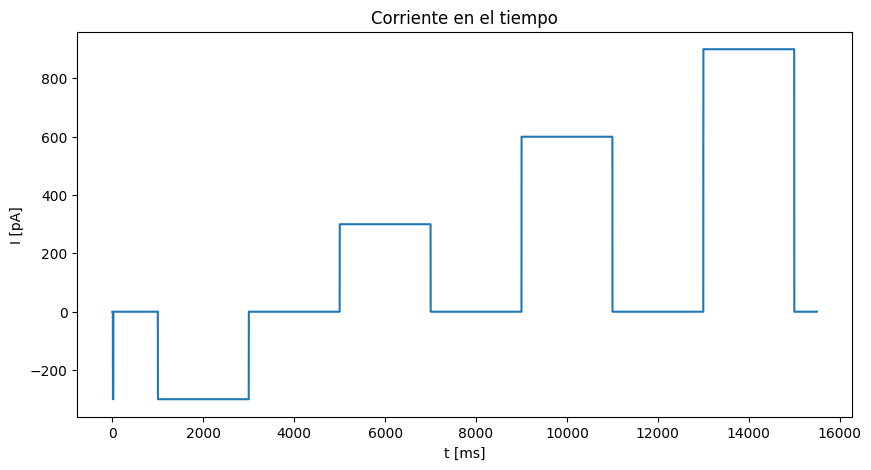

In [8]:
# graficamos
spike_times, training_peaks_h = find_peaks(v_train, height=0)
plt.figure(figsize=(10, 5))
plt.plot(t/ms, v_train, "k-", linewidth=0.5)
plt.scatter(spike_times / (fs * ms), v_train[spike_times], marker="*",label="disparos")
plt.xlabel('t[ms]')
plt.ylabel('V[mv]')
plt.title('Tension en el tiempo')
plt.yticks(np.arange(-80, 50, 5))
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(t/ms, I_train/pA)
plt.xlabel('t [ms]')
plt.ylabel('I [pA]')
plt.title('Corriente en el tiempo')
plt.show()

## Metodos Utilizados


# HyH

El modelo HyH intenta caracterizar la apertura y cierre de los canales de Sodio y Potasio de la membrana de la neurona que harán que la concentración de iones suba o baje y que en definitiva el potencial de membrana cambie. HyH trata de relacionar las neuronas con componentes electrónicos cuyo comportamiento se conoce matemáticamente, para de esta manera poder formar un modelo matemático. Se modela a cada compuerta como una conductancia g y a la membrana como un capacitor. 


Donde se plantea el modelo como la siguiente combinacion de EDOS:


donde:

\begin{aligned}
C \dot{v}(t) &=i(t)-g_{\mathrm{Na}} m^3 h\left(v-v_{\mathrm{Na}}\right)-g_{\mathrm{K}} n^4\left(v-v_{\mathrm{K}}\right)-g_{\mathrm{L}}\left(v-v_{\mathrm{L}}\right) \quad t>0, \\
\dot{n} &=\alpha_n(v)(1-n)-\beta_n(v) n, \\
\dot{m} &=\alpha_m(v)(1-m)-\beta_m(v) m, \\
\dot{h} &=\alpha_h(v)(1-h)-\beta_h(v) h . \\
\\
\end{aligned}


donde $\alpha_x, \beta_x$ se expresan en $\mathrm{ms}^{-1}, g_x$ en $\mathrm{mS} / \mathrm{cm}^3, v_x$ en $\mathrm{mV}$ y $C$ en $\mu \mathrm{F} / \mathrm{cm}^3$, y donde:


\begin{aligned}
&\alpha_n(v)=0.010 \frac{v+55}{1-e^{-\frac{v+55}{10}}}, \quad \beta_n(v)=0.125 e^{-\frac{v+65}{80}}, \\
&\alpha_m(v)=0.100 \frac{v+40}{1-e^{-\frac{v+40}{10}}}, \quad \beta_m(v)=4.000 e^{-\frac{v+65}{18}}, \\
&\alpha_h(v)=0.070 e^{-\frac{v+65}{20}}, \quad \quad \beta_h(v)=\frac{1}{1+e^{-\frac{v+35}{10}}}, \\
&g_{\mathrm{Na}}=120, \quad g_{\mathrm{K}}=+36, \quad g_{\mathrm{L}}=0.3, \\
&v_{\mathrm{Na}}=50, \quad v_{\mathrm{K}}=-77, \quad v_{\mathrm{L}}=-54.4, \\
&C=1 . \\
&
\end{aligned}


Para las simulaciones que realizaremos, asumiremos que la corriente aplicada se fija a un valor constante, de modo que $i(t)=i_0 , \forall t > 0$

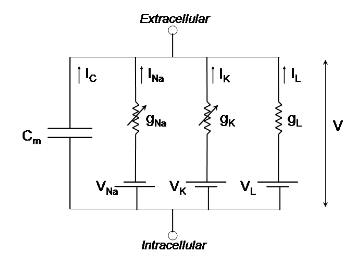

Implementamos nuestro modelo HyH y lo simulamos frente a una corriente constante de 10 micro amper por centimetro cubico

### Definimos todo el funcionamiento de HyH en una clase, vamos a mostrar fragmentos de codigo para explicar brevemente que hace y como funciona. No hay que correr este codigo es meramente para visualizar el interior de la clase

En el siguiente codigo se definen las funciones alfa y beta:

In [ ]:

@staticmethod
def alpha_n(v: float):
    return 0.010 * (v + 55)/(1 - np.exp(-(v + 55)/(10)))

@staticmethod
def alpha_m(v: float) -> float:
    return 0.100 * (v + 40) / (1 - np.exp(-(v + 40) / (10)))

@staticmethod
def alpha_h(v: float) -> float:
    return 0.070 * np.exp(-(v + 65) / (20))

@staticmethod
def beta_n(v: float) -> float:
    return 0.125 * np.exp(-(v + 65) / 80)

@staticmethod
def beta_m(v: float) -> float:
    return 4.0 * np.exp(-(v + 65) / 18)

@staticmethod
def beta_h(v: float) -> float:
    return 1 / (1 + np.exp(-(v + 35) / 10))

Definimos a la derivada a resolver:




In [ ]:
def derivative(self, t: float, X: np.ndarray, i: Callable) -> np.ndarray:
        """
        Instantenous derivative for the Hodgkin and Huxley model
        :param: X: np.array([v, n, m, h])
        :param: i: current as a function of time
        :return: np.array([dv, dn, dm, dh])/dt
        """
        # Define constants
        s = self
        v = X[0]
        n = X[1]
        m = X[2]
        h = X[3]
        # Compute derivative
        dv = (i(t) - s.g_Na * m ** 3 * h * (v - s.V_Na) - s.g_K * n ** 4 * (v - s.V_K) - s.g_L * (v - s.V_L)) / s.C
        dn = s.alpha_n(v) * (1 - n) - s.beta_n(v) * n
        dm = s.alpha_m(v) * (1 - m) - s.beta_m(v) * m
        dh = s.alpha_h(v) * (1 - h) - s.beta_h(v) * h
        return np.array([dv, dn, dm, dh])

Finalmente Simulamos usando nuestro metodo de resolucion de EDOS preferido, en este caso runge kutta 4:

In [ ]:
def simulate_trajectory(self, t: np.ndarray,
                            i: Callable,
                            plot: bool = False,
                            t_units: float = 1,
                            v_units: float = 1) -> Tuple[np.ndarray, List[int]]:
        """
        :param np.ndarray t: time array of len N, defined as the range a:h:b
        :param np.ndarray i: current as a function of time
        :param plot: indicates whether to plot
        :param t_units: for plotting purposes
        :param v_units: for plotting purposes

        Uses the Runge-Kutta 4 method to solve the model

        :return  X such that. X[0, :] = V, X[1, :] = n, X[2, :] = m, X[3, :] = h, and spike times
        """
        s = self
        X_0 = np.array([s.V_init, s.n_init, s.m_init, s.h_init])
        derivative = lambda t_val, X_arr, i_func : self.derivative(t_val, X_arr, i_func)
        res = solve_ivp(derivative, t_span=(t[0], t[-1]), args=(i,), t_eval=t, method='LSODA', y0=X_0)
        X = res.y
        V = X[0, :]
        spike_times = list(find_peaks(V, height=0)[0])

        if plot:
            fig, ax = plt.subplots()
            ax.plot(t/t_units, V/v_units, 'k-', linewidth=0.5)
            ax.set_xlabel('t [ms]')
            ax.set_ylabel('V [mV]')
            plt.show()

        return X, spike_times

### Finalmente probamos el metodo y podemos ver como describe de manera acertada el comportamiento de las neuronas frente  al corriente y sus respectivos disparos 

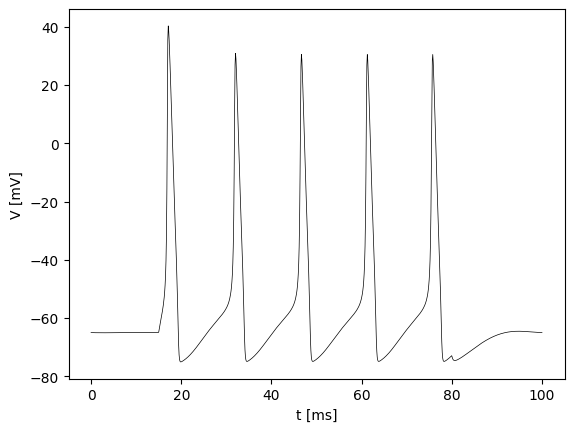

In [9]:
test_hyh()


# Leaky integrate and fire

El modelo LIF plantea la siguiente ecuación para el potencial de membrana:

\begin{equation}
\tau_m\frac{dV}{dt} = -(V-E_L) + \frac{I}{g_L}\,
\end{equation}

Donde $V$ es el potencial de membrana, $g_L$ es la conductancia de fuga, $E_L$ es el potencial de reposo, $I$ es el valor de entrada de la corriente externa y  $\tau_m$ es la constante de tiempo de la membrana. Además, se agrega la condición de que cuando la neurona excede un potencial umbral $V_{th}$, indicamos que hubo un disparo y el potencial automáticamente vuelve a su valor de reposo. Luego, durante un período refractario $t_{ref}$, el potencial queda fijo en dicho valor.

### Al igual que con HyH modelamos LIF dentro de una clase, por lo que vamos a mostrar el funcionamiento del mismo con fragmentos de codigo que no

Calculamos la derivada:

In [ ]:
def derivative(self, I_val: float, u: float) -> np.ndarray:
        """
        Computes the instantaneous derivative
        :param I_val: current current (hehe)
        :param u: current voltage
        :return: du/dt
        """
        s = self  # alias for neat code
        du = -(u - s.E_L) + I_val / s.g_L
        return du / s.tau_m

Simulamos teniendo en cuenta tanto el reseteo como el periodo refractario:

In [ ]:
def simulate_trajectory(self, t: np.ndarray,
                            I_input: np.ndarray,
                            plot: bool = False,
                            t_units: float = ms,
                            v_units: float = mV) -> Tuple[np.ndarray, np.ndarray]:
        """
        Solves IVP to find the trajectory v(t)
        :param t: time samples
        :param I_input: input current, same shape as t
        :param plot: indicates whether to plot
        :param t_units: for plotting purposes
        :param v_units: for plotting purposes
        :return: V, same shape as t, and a list of spike times
        """
        s = self
        V = np.zeros_like(t)
        dt = t[1] - t[0]
        V[0] = self.V_init
        ref_counter = 0
        spike_times = []
        # Simulamos
        for i in range(1, len(t)):
            V_next = V[i - 1] + s.derivative(I_input[i - 1], V[i - 1]) * dt

            # Caso 1: estamos en periodo refractario
            if ref_counter > 0 or V[i - 1] == s.V_fire:
                V[i] = s.V_reset
                ref_counter -= dt

            # Caso 2: disparo
            elif V_next >= s.V_th:
                V[i] = s.V_fire
                ref_counter = s.tref
                spike_times.append(i)

            # Caso 3: nada en particular, integramos
            else:
                V[i] = V_next

        if plot:
            plot_voltage(t, V, t_units, v_units)

        return V, np.array(spike_times)

### Testeamos

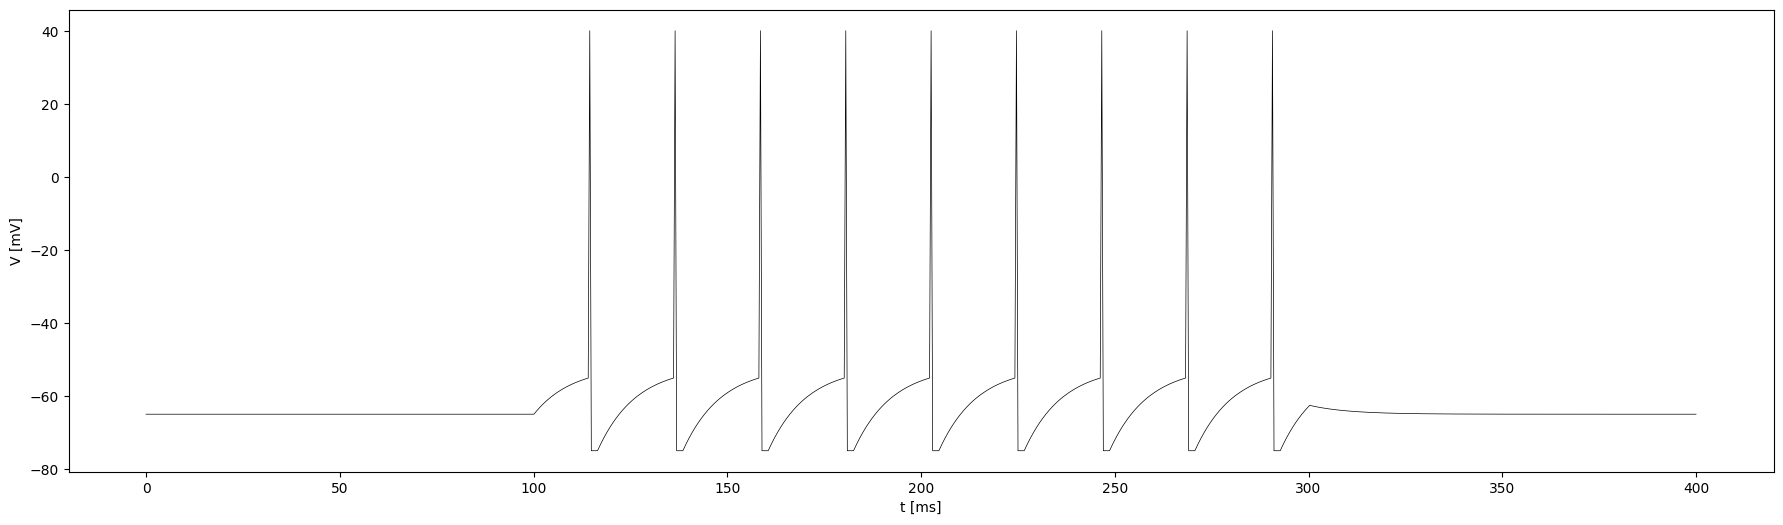

In [10]:
test_lif()

## AdEx

La familia de los modelos Integrate and Fire adaptativos plantean una ampliación del modelo Leaky Integrate and Fire (LIF) en donde el potencial de membrana (V o u, según el autor) depende de:

La corriente de entrada integrada de aferencias, I(t)
Una no linealidad en el sistema, f(u)
La sumatoria de las corrientes adaptativas, wk(t)

Expresado como sistema de ecuaciones diferenciales, obtenemos

$$
\begin{aligned}
\tau_m \frac{\mathrm{d} u}{\mathrm{~d} t} & =f(u)-R \sum_k w_k+R I(t) \\
\tau_k \frac{\mathrm{d} w_k}{\mathrm{~d} t} & =a_k\left(u-u_{\text {rest }}\right)-w_k+b_k \tau_k \sum_{t^{(f)}} \delta\left(t-t^{(f)}\right)
\end{aligned}
$$

Donde R es la resistencia eléctrica del sistema, urest es el potencial de reposo, los τi son constantes de tiempo, y los bk indican el salto discreto que ocurre en las corrientes wk en los instantes de disparo, t(f) .

La evidencia experimental demostró que una buena elección para la no linealidad del sistema es una función exponencial sumada a la diferencia entre el potencial instantáneo y un potencial de reposo. Esto da origen al modelo Adaptive Exponential Integrate and Fire (AdEx), el cual se rige por las siguientes ecuaciones (asumiendo una única corriente adaptativa w):

$$
\begin{aligned}
& \tau_m \frac{\mathrm{d} u}{\mathrm{~d} t}=-\left(u-u_{\text {rest }}\right)+\Delta_T \exp \left(\frac{u-\vartheta_{r h}}{\Delta_T}\right)-R w+R I(t) \\
& \tau_w \frac{\mathrm{d} w}{\mathrm{~d} t}=a\left(u-u_{\text {rest }}\right)-w+b \tau_w \sum_{t^{(f)}} \delta\left(t-t^{(f)}\right) . \\
&
\end{aligned}
$$

al igual que en el clásico LIF, el potencial se resetea instantáneamente a urest luego de disparar.

### Como hicimos anteriormente mostramos fragmentos de codigo de Adex:

definimos la derivada:

In [ ]:
def derivative(self, I_val: float, u: float, w: float) -> np.ndarray:
        """
        Computes instantaneous derivative
        Args:
            I_val (float): instantaneous current
            u (float): instantaneous voltage
            w (float): instantenous adaptative current

        Returns:
            np.ndarray: np.array([du/dy, dv/dt])
        """
        s = self # alias for neater code

        du = -(u - s.V_rest) + s.delta_T*np.exp((u - s.V_rh)/s.delta_T) - s.R*w + s.R*I_val
        dw = s.a*(u - s.V_rest) - w

        return np.array([du/s.tau_m, dw/s.tau_w])

El codigo de la simulacion del modelo:

In [ ]:
def simulate_trajectory(self, t: np.ndarray,
                            I_input: np.ndarray,
                            plot: bool=False,
                            t_units: float=ms,
                            v_units: float=mV) -> Tuple[np.ndarray, np.ndarray]:
        """
        Resuelve numericamente un problema de valor inicial para el modelo LIF

        t: muestras temporales equiespaciadas
        I_arr: muestras de la corriente en los instantes de t
        plot: indica si graficar o no la trayectoria junto al estímulo
        I_units: defaultea a [pA]
        t_units: defaultea a [ms]
        v_units: defaultea a [mV]

        returns: X, tal que X[0, :] = V, y X[1, :] = w
                spike_times: lista con los indices donde ocurre un disparo

        """
        X_0 = np.array([self.V_init, self.w_init])

        t_len = len(t)
        dt = t[1] - t[0]
        spike_times = []

        # inicializamos V
        X = np.zeros((2, t_len)) # X[0, :] = u ; X[1, :] = w
        X[:, 0] = X_0

        # Simulamos
        for i in range(1, t_len):
            X_prev = X[:, i-1]
            X_next = X_prev + self.derivative(I_input[i-1], X_prev[0], X_prev[1])*dt
            u_next, w_next = X_next[0], X_next[1]

            # Caso: disparo, y tenemos que resetear
            if u_next > self.V_thres:
                X[0, i-1] = self.V_postreset
                u_next = self.V_reset
                w_next += self.b
                spike_times.append(i-1)

            X[:, i] = np.array([u_next, w_next])

        if plot:
            V = X[0, :]
            plot_voltage(t, V, t_units, v_units)

        return X, np.array(spike_times)

### Testeamos

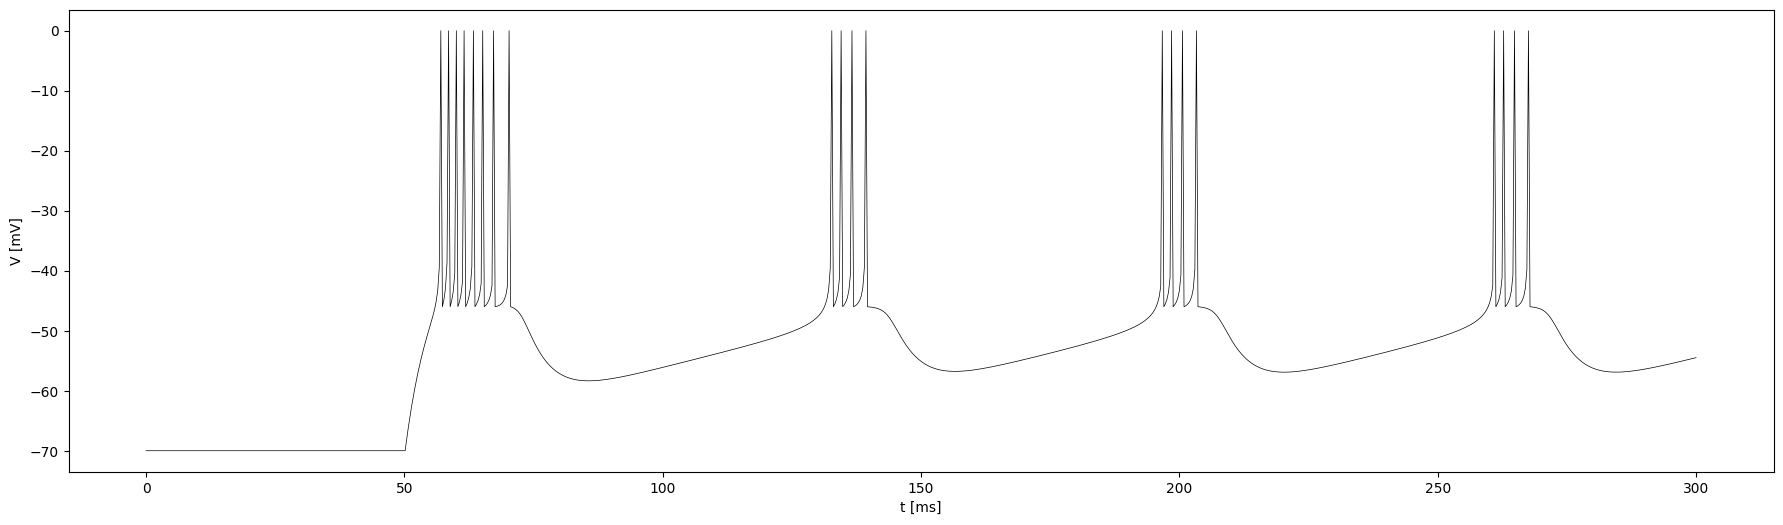

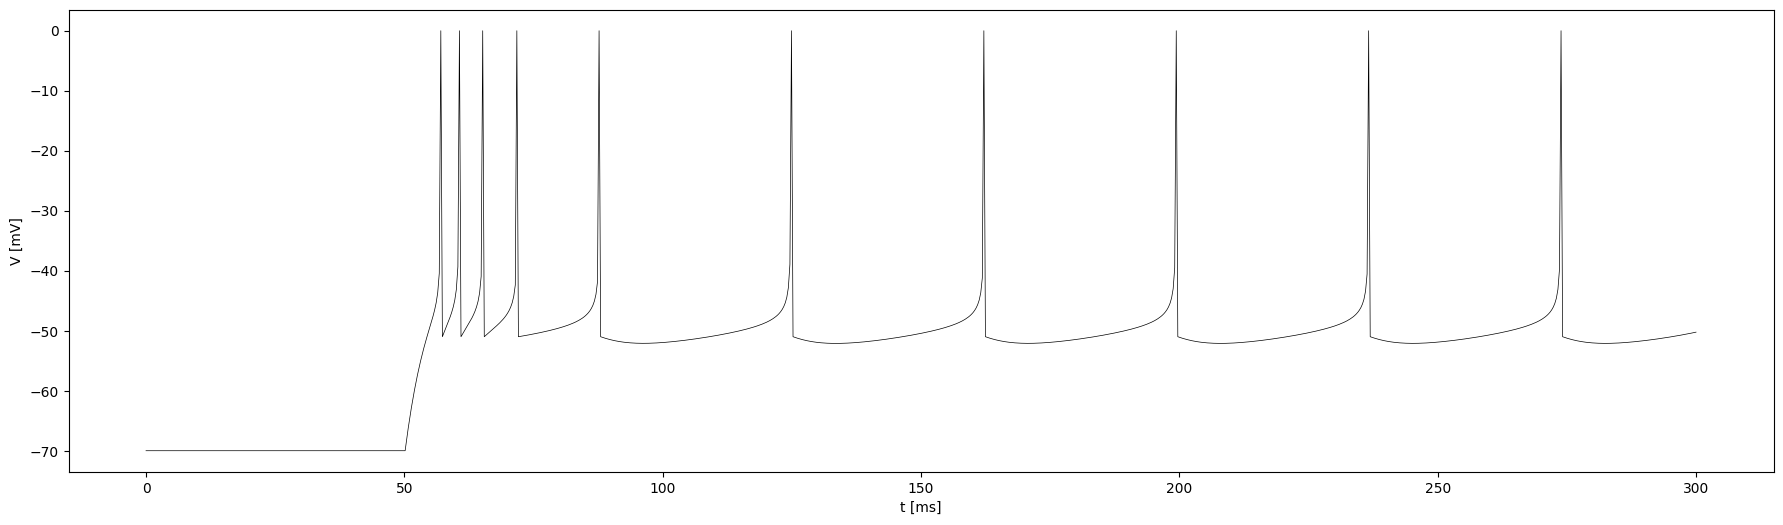

c:\Users\Juan Bautista\.vscode\Tp Final Neuro\Neuro-16-82\Trabajo Final\neuron_models\adex.py:61: RuntimeWarning: overflow encountered in exp
  du = -(u - s.V_rest) + s.delta_T*np.exp((u - s.V_rh)/s.delta_T) - s.R*w + s.R*I_val
c:\Users\Juan Bautista\.vscode\Tp Final Neuro\Neuro-16-82\Trabajo Final\neuron_models\adex.py:61: RuntimeWarning: invalid value encountered in scalar add
  du = -(u - s.V_rest) + s.delta_T*np.exp((u - s.V_rh)/s.delta_T) - s.R*w + s.R*I_val


Generation 0: Best Fitness = 2.9412e-02 Params: [7.405134, 0.999414, 99.957799, 7.699591, -49.264399, 3.041310]
Generation 1: Best Fitness = 2.9412e-02 Params: [7.405134, 0.999414, 99.957799, 7.699591, -49.264399, 3.041310]
Generation 2: Best Fitness = 3.3333e-02 Params: [5.063700, -0.121657, 100.573416, 5.150959, -51.844089, 0.422579]
Generation 3: Best Fitness = 3.3333e-02 Params: [5.063700, -0.121657, 100.573416, 5.150959, -51.844089, 0.422579]
Generation 4: Best Fitness = 3.3333e-02 Params: [5.063700, -0.121657, 100.573416, 5.150959, -51.844089, 0.422579]
Generation 5: Best Fitness = 3.3333e-02 Params: [5.063700, -0.121657, 100.573416, 5.150959, -51.844089, 0.422579]
Generation 6: Best Fitness = 3.3333e-02 Params: [5.063700, -0.121657, 100.573416, 5.150959, -51.844089, 0.422579]
Generation 7: Best Fitness = 3.3333e-02 Params: [5.063700, -0.121657, 100.573416, 5.150959, -51.844089, 0.422579]
Generation 8: Best Fitness = 3.3333e-02 Params: [5.063700, -0.121657, 100.573416, 5.150959, 

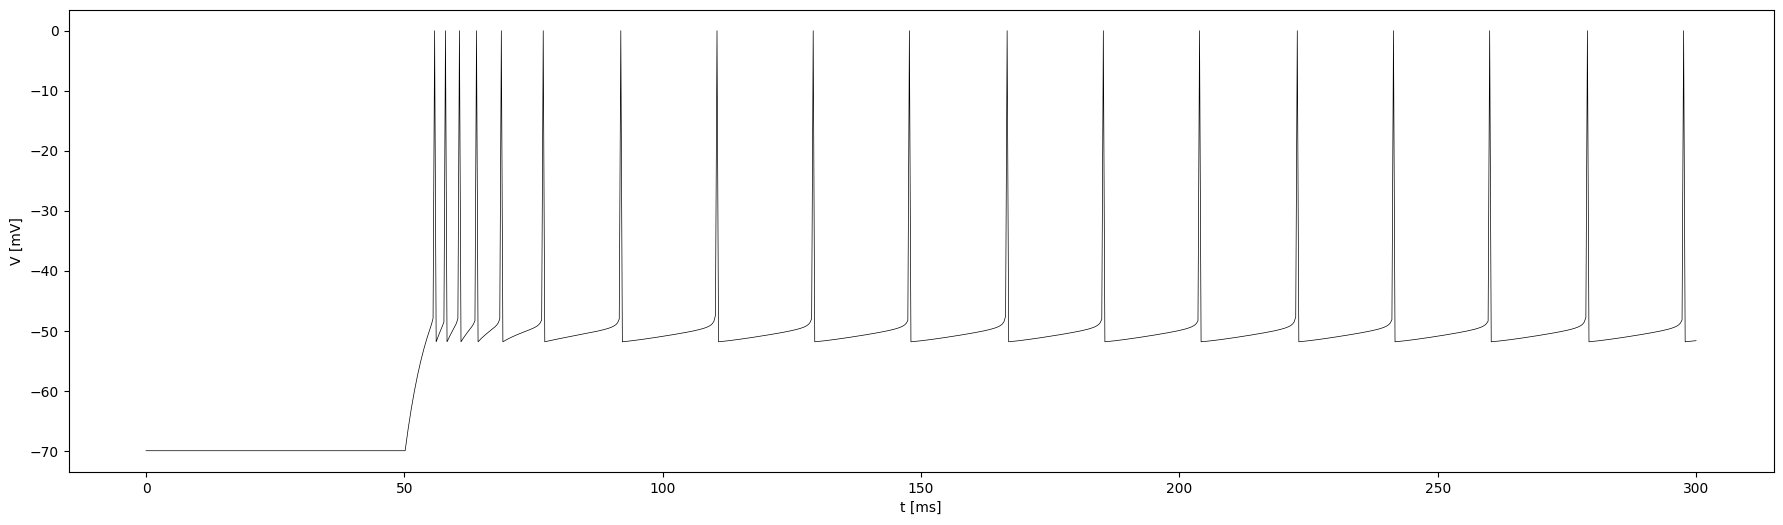

In [11]:
test_adex()

Se puede observar como respeta el comportamiento esperado por un modelo AdEx lo cual es un buen indicador de que nuestro modelo esta bien construido

Donde por ejemplo para la comparación entre los disparos tónicos y el low input. En el caso sin adaptación los disparos de las neuronas siguen una frecuencia constante, la frecuencia no sufre cambios en el tiempo caso, sin embargo en el modelo adaptativo a medida que la neurona recibe un input la frecuencia de disparo va aumentando (esto se puede observar con la distancia entre disparos en low adapting). El mismo comportamiento se puede observar en Burst donde al principio la frecuencia de disparo es muy alta y luego termina siendo hasta más baja que sin la adaptación. 


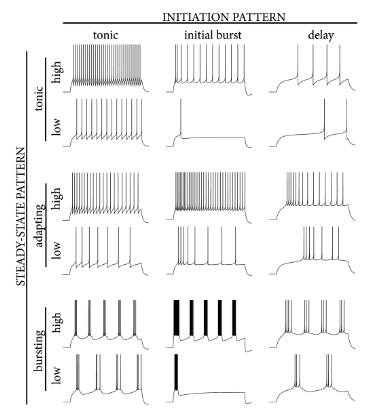

Veamos el efecto de los parametros a y b sobre AdEx

In [49]:
def interactive_AdEx(a=0.5, b=7):
  """
  Funcion para raelizar simulaciones interactivas con AdEx variando a y b
  """
  # Definimos un pulso de tiempo y una corriente aplicada
  t_arr = np.linspace(0, 0.3, 1000)
  i_0 = 65e-12
  i_func = np.vectorize(lambda t: i_0*(t>0.01)*(t<0.250))
  I_arr = i_func(t_arr)

  # Fijamos pars
  pars = default_pars_adex()
  pars['a'] = a*1e-9
  pars['b'] = b*1e-12

  # Simulamos
  X, spike_times = solve_ivp_adex(t_arr, I_arr, pars)
  v_adex = X[0, :]
  w_adex = X[1, :]

  # Graficamos
  i = np.arange(len(v_adex))
  norm = plt.Normalize(i.min(), i.max())
  cmap = cm.plasma
  fig, ax = plt.subplots(figsize=(10, 5))
  ax.plot(t_arr, v_adex*1e3, 'red')
  ax.plot(t_arr, I_arr*1e11, 'k--')
  ax.set_xlabel('t [ms]')
  ax.set_ylabel('u [mv]')
  ax.set_title(f"Firing pattern de AdEx con parametros a={pars['a']*1e9:.3f} [nS],"
               f"b={pars['b']*1e12:.3f} [pA]")
  plt.grid('on', linestyle='-.')
  plt.show()
  fig, ax = plt.subplots()
  sc = ax.scatter(v_adex, w_adex, c=i, s=1, cmap=cmap, norm=norm)
  cbar = plt.colorbar(sc)
  cbar.set_label('evolucion a lo largo del tiempo')
  plt.title('Simulación con AdEx')
  plt.xlabel('u [mV]')
  plt.ylabel('w [na]')
  plt.grid(True)
  plt.show()

In [50]:
_ = widgets.interact(interactive_AdEx, a=(0, 5, 0.1), b=(0, 15, 0.2))

In [17]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
data = [
    ["Tipo", "Mecanicista", "Mecanicista", "Mecanicista"],
    ["Nivel de análisis", "Implementación", "Implementación", "Implementación"],
    ["Ventajas", "Modelo exhaustivo basado en la configuración molecular de la membrana celular, directamente relacionado con fenómenos de corrientes iónicas moduladas por canales voltaje-dependientes. Sin embargo, es computacionalmente pesado, dado que requiere de un sistema de 4 ecuaciones diferenciales no lineales acopladas", 
     "Modelo simplificado de HyH donde solo se considera una única corriente y además se tienen en cuenta un término de fuga. De los 3 comparados es el más simple a nivel matemático y computacional.",
     "Más complejo que LIF pero menos que HyH, lo cual nos da el punto medio entre ambos. La principal ventaja es que tiene en cuenta la adaptación de las neuronas y nos permite describir estos procesos."],
    ["Objetivos de K.K.", "Microscopicamente realista Representacional Interpretable Elegante", 
     "Compacto Analiticamente tratable Interpretable", 
     "Inspiración para experimentos Realismo comportamental Representacional Microscopicamente Realista"],
    ["Ejemplo de falla", "Es demasiado complejo a la hora de representar sistemas que involucren la interacción entre múltiples neuronas acopladas. Computacionalmente caro a gran escala.",
     "No es útil para modelar procesos de adaptación, por ejemplo los disparos de neuronas del circuito retiniano ante la llegada de luz a lo largo del tiempo",
     "Simulación de bloqueo de canales de potasio o Sodio."]
]

columns = ["Caracteristica", "HyH", "LIF", "AdEx"]

tabla = pd.DataFrame(data, columns=columns)

tabla


,Caracteristica,HyH,LIF,AdEx
0,Tipo,Mecanicista,Mecanicista,Mecanicista
1,Nivel de análisis,Implementación,Implementación,Implementación
2,Ventajas,"Modelo exhaustivo basado en la configuración molecular de la membrana celular, directamente relacionado con fenómenos de corrientes iónicas moduladas por canales voltaje-dependientes. Sin embargo, es computacionalmente pesado, dado que requiere de un sistema de 4 ecuaciones diferenciales no lineales acopladas",Modelo simplificado de HyH donde solo se considera una única corriente y además se tienen en cuenta un término de fuga. De los 3 comparados es el más simple a nivel matemático y computacional.,"Más complejo que LIF pero menos que HyH, lo cual nos da el punto medio entre ambos. La principal ventaja es que tiene en cuenta la adaptación de las neuronas y nos permite describir estos procesos."
3,Objetivos de K.K.,Microscopicamente realista Representacional Interpretable Elegante,Compacto Analiticamente tratable Interpretable,Inspiración para experimentos Realismo comportamental Representacional Microscopicamente Realista
4,Ejemplo de falla,Es demasiado complejo a la hora de representar sistemas que involucren la interacción entre múltiples neuronas acopladas. Computacionalmente caro a gran escala.,"No es útil para modelar procesos de adaptación, por ejemplo los disparos de neuronas del circuito retiniano ante la llegada de luz a lo largo del tiempo",Simulación de bloqueo de canales de potasio o Sodio.


## Metodos de Fiteo y como encontrarlos

Una vez fabricados nuestros modelos resta crear metodos para poder fitear los disparos de las neuronas con los disparos de la simulacion. Para ello lo que vamos a hacer es minimizar el error que se produce entre las tasas de disparos de las neuronas simuladas y las reales. En un principio intentamos utilizar cuadrados minimos sin embargo no lograba cumplir con nuestras expectativas, por lo que aplicamos fue un metodo llamado Algoritmo Genetico.

En que se basa este algoritmo:
* 1) Primero se genera una poblacion de posibles parametros solucion al modelo
* 2) Luego se seleccionan los que tienen mejor "Fitteo", es decir se evalua que tan buena solucion es
* 3) Despues se genera un crossover entre soluciones 
* 4) Este crossover tiene la posibilidad de sufrir mutaciones que son variaciones aleatorias, la posibilidad de sufrir una mutacion se define con el mut_rate
* 5) Se genero una nueva poblacion y se vuelve a empezar con el algoritmo hasta que se cumple una cierta cantidad de repeticiones

In [ ]:
class GeneticAlgorithm(object):
    def __init__(self, pop_size: int,
                 N_iter: int,
                 max_rep: int,
                 mut_rate: float,
                 mut_scale: float,
                 fitness_function: Callable,
                 init_pars: np.ndarray):
        """
        Definimos el objeto de algoritmo genético
        :param pop_size: cantidad de individuos en la población
        :param N_iter: cantidad máxima de generaciones
        :param max_rep: cantidad máxima permitida de genraciones sucesivas sin mejora
        :param mut_rate: pernece a [0, 1], indica la probabilidad de mutar de un individuo
        :param fitness_function: función que define qué tan buena es una población
        :param init_pars: valores iniciales para los parámetros del algoritmo
        """

        self.pop_size = pop_size
        self.N_iter = N_iter
        self.max_rep = max_rep
        self.mut_rate = mut_rate
        self.mut_scale = mut_scale
        self.fitness_function = fitness_function
        self.population = self.initialize_population(init_pars)

#1) 
    def initialize_population(self, init_pars: np.ndarray) -> np.ndarray:
        return init_pars + np.random.normal(size=(self.pop_size, init_pars.size))

#2)
    def select_parents(self, fitnesses, num_parents):
        return self.population[np.argsort(fitnesses)[-num_parents:]]

#3)
    def crossover(self, parents, offspring_size: Tuple[int, int]):
        crossover_point = offspring_size[1] // 2
        parent1_idx = np.arange(offspring_size[0]) % parents.shape[0]
        parent2_idx = (np.arange(offspring_size[0]) + 1) % parents.shape[0]
        offspring = np.empty(offspring_size)
        offspring[:, :crossover_point] = parents[parent1_idx, :crossover_point]
        offspring[:, crossover_point:] = parents[parent2_idx, crossover_point:]
        return offspring

#4)
    def mutate(self, offspring):
        mutations = np.random.rand(*offspring.shape) < self.mut_rate
        mutation_values = np.random.normal(size=offspring.shape, scale=self.mut_scale)
        offspring = np.where(mutations, offspring + mutation_values, offspring)
        return offspring

#2)
    def evaluate_fitness(self, population, *args, **kwargs):
        with ThreadPoolExecutor() as executor:
            fitnesses = list(executor.map(lambda params: self.fitness_function(params, *args, **kwargs), population))
        return np.array(fitnesses)

#5)
    def genetic_algorithm(self, *args, **kwargs) -> np.ndarray:
        """
        Generar poblaciones iterativas, seleccionar a los mas aptos, reproducirlos, mutar algunos, repetir
        :param args: argumentos por posicion para la funcion de fitness
        :param kwargs: argumentos por keyword para la funcion de fitness
        :return: la mejor combinacion de parametros
        """
        param_size = self.population.shape[1]
        best_solution = self.population[0]
        best_fitness = -np.inf
        rep_count = 0

        for generation in range(self.N_iter):
            # Hallamos la fitness de cada miembro de la poblacion
            fitnesses = np.array([self.fitness_function(params, *args, **kwargs) for params in self.population])
            # Identificamos al mejor, y actualizamos de ser el necesario
            max_fitness_idx = np.argmax(fitnesses)
            if fitnesses[max_fitness_idx] > best_fitness:
                rep_count = 0
                best_fitness = fitnesses[max_fitness_idx]
                best_solution = self.population[max_fitness_idx].copy()

            # Seleccion de padres, crossover, y mutacion
            parents = self.select_parents(fitnesses, self.pop_size // 2)
            offspring_crossover = self.crossover(parents, (self.pop_size - parents.shape[0], param_size))
            offspring_mutation = self.mutate(offspring_crossover)

            # Actualizacion de la poblacion
            self.population[:parents.shape[0]] = parents
            self.population[parents.shape[0]:] = offspring_mutation

            # Strings para mostrar al usuario
            par_str = ', '.join([f"{par:3f}" for par in best_solution])
            print(f"Generation {generation}: Best Fitness = {best_fitness:.4e}", end=' ')
            print(f"Params: [{par_str}]")

            rep_count += 1
            # Si llevamos más de max_rep generaciones sin mejorar, nos quedamos con lo que tenemos
            if rep_count > self.max_rep:
                print('No more evolution')
                break

        return best_solution

# Resultados

Entrenamos nuestro modelo AdEx con la corriente de entrenamiento, algunas variables estan predifinidas en vista a lo observado en los ploteos de la tension y en numerosas repeticiones del algoritmo para mejorar los tiempos de computo de la funcion

* nota: no corran la celda ya que el propio git tiene guardado los parametros con los que mejor fiteo

In [13]:
adex = Adex_model(V_reset = -50*mV,
                  V_thres = -35*mV,
                  V_postreset = 40*mV,
                  b = 450*pA,
                  V_rest = -65*mV,
                  delta_T = 1.0*mV)


In [2]:

adex.fit_spikes(t,
                spike_times,
                I_train,
                n_per_bin=len(t)//10,
                tweak_keys=['a', 'b', 'delta_T', 'tau_m', 'tau_w', 'R'],
                tweak_units=[nS, pA, mV, ms, ms, Mohm],
                N_iter=100,
                max_rep=15,
                pop_size=50,
                mut_rate=0.1,
                mut_scale=10)


NameError: name 'Adex_model' is not defined

Procedemos a Simular con la corriente de entrenamiento

* se puede observar como se respeta el comportamiento de la tension comparaado a la tension medida

* en cuanto a los trenes de disparos se respetan tanto los tiempos en los que ocurren como la cantidad de los mismos

* Sin embargo el modelo falla al representar la magnitud de la tension, si bien la tension de reposo esta definida ocurren minimos de -500mV algo que resulta incompatible con la tension medida


Creemos que estos errores en el fiteo pueden mejorar si:

* Utilizamos un mejor algoritmo de fiteo: El algoritmo Genetico requiere mucha materia de computo para conseguir estos resultados, solo llegar a estos parametros requirio de media hora de computo

* Definimos mejor los valores semilla: A lo largo de numerosas iteraciones notamos que el fiteo y su convergencia mejoran si eligimos valores semilla mas cercanos a los de la realidad (cosa que hace muchisimo sentido), aun asi la idea de estos metodos es hallar valores que desconocemos por lo que no tendria sentido asignarles valores si no que seria como un fiteo a la fuerza y a ojimetro

* En lugar de valores semillas podriamos tomar valores aleatorios en un rango determinado para poder sumar aleatoridad y evitar caer en un punto silla por accidente

* Aumentar la variabilidad entre generaciones: las mutaciones estan definidas para ser normales de desvio 1, si aumentamos el desvio entre generaciones podriamos mejorar la variabilidad genetica y hayar mejores soluciones

* Tal vez AdEx no es el mejor modelo para adaptar esta corriente y cambiando el modelo los resultados mejores

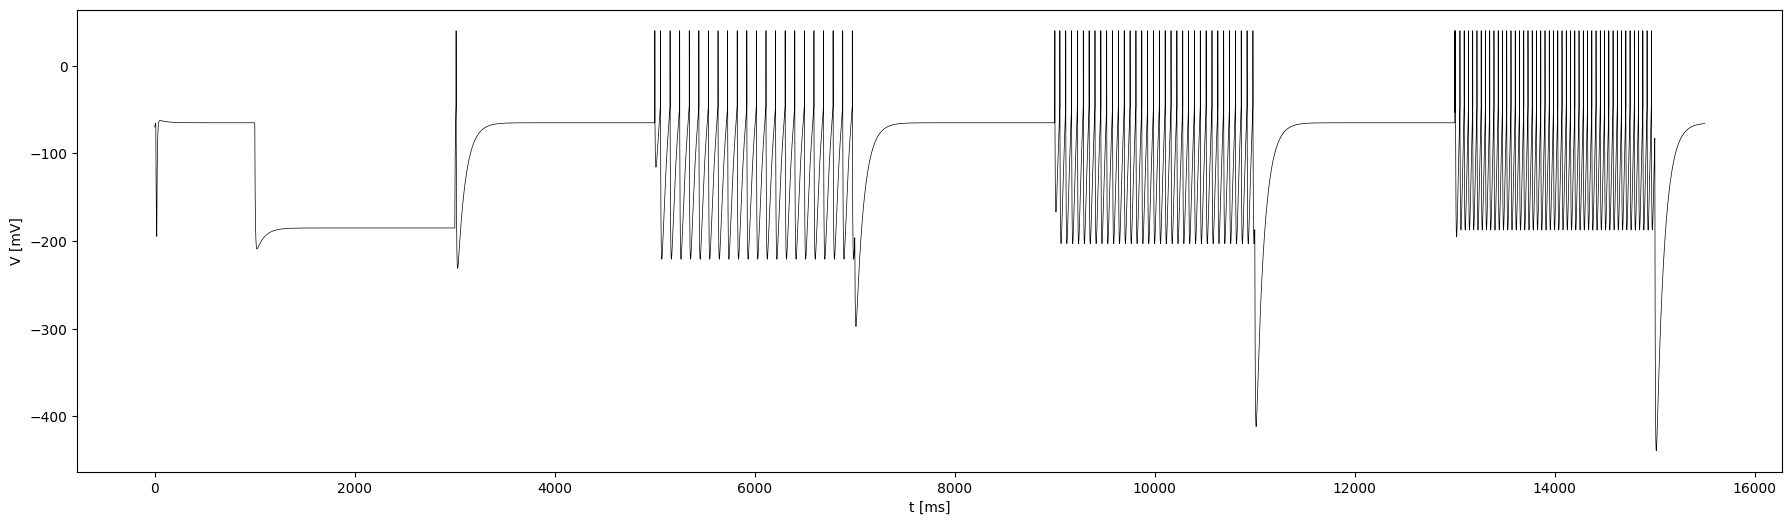

In [14]:
X, sim_spikes = adex.simulate_trajectory(t, I_train, plot=True)

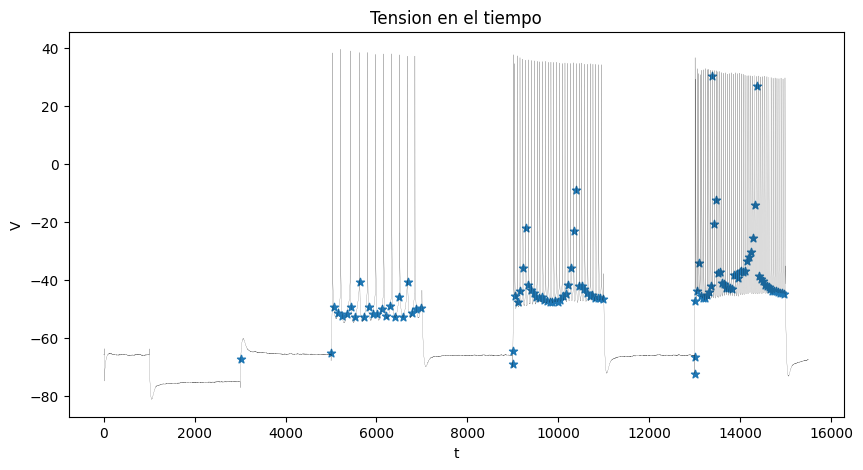

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(t/ms,v_train, "k-", linewidth=0.1)
plt.scatter(np.array(sim_spikes)/(fs*ms),v_train[sim_spikes],marker="*")
plt.xlabel('t')
plt.ylabel('V')
plt.title('Tension en el tiempo')
plt.show()


Por otro lado simulamos la respuesta de AdEx frente a la corriente de testeo y la comparamos con la respuesta medida y no se puede discernir realmente si representa apropiadamente el comportamiento de la neurona ya que al ser una señal tan ruidosa no se puede inferir si tiene o no el comportamiento o si es hasta ruido del equipamiento utilizado para medir. Por otro lado se podrian usar filtros pasabajos para tratar de representar mejor la señal medida pero no llegamos a implementarlos.

Text(0.5, 1.0, 'Tension medida post entrenamiento')

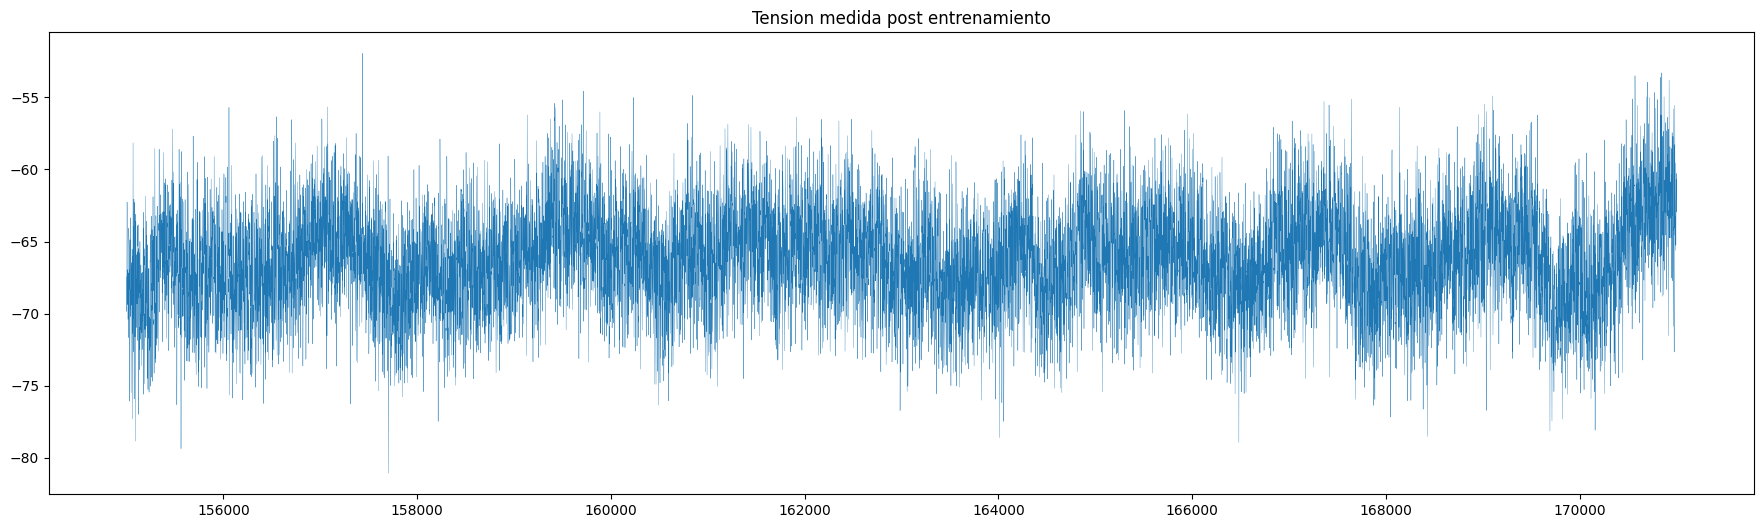

In [26]:

plt.figure(figsize=(22,6))
plt.plot(v_test[0:16000],linewidth = .25)
#plt.scatter(spikes_adex_test,v_test[spikes_adex_test])
plt.title("Tension medida post entrenamiento")

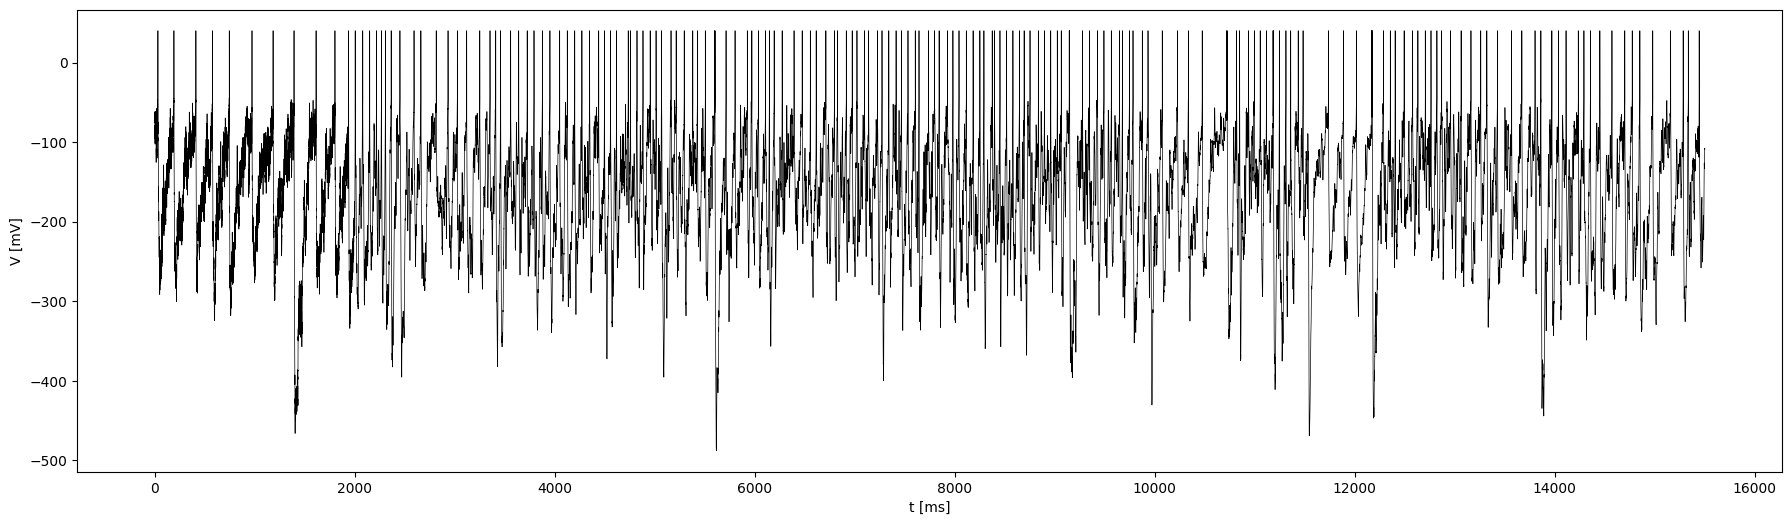

[   314   1915   4112   5771   7451   9722  11831  13923  13926  16131
  18017  19386  20041  20044  20795  21490  22163  22663  23075  23642
  24515  25926  26610  28146  29327  30256  31190  32499  33523  34093
  34584  35589  36391  37244  37923  38757  39514  40489  41251  41993
  42711  43483  44392  44967  45571  46175  47347  47572  48222  48821
  49543  50129  50661  51625  52141  52946  53797  54265  55054  55999
  56020  57128  58029  59254  59705  60362  61076  61459  61941  62741
  63928  64743  65554  66143  67108  67967  68275  69152  69744  70218
  70977  71386  72262  72722  73399  74131  74673  75320  76049  76422
  77378  77972  78437  79270  79813  80422  81154  81834  82510  82913
  83745  83975  84518  85171  85813  86473  86939  87524  88362  88969
  89593  90251  90649  91447  91483  92772  93464  94270  94915  95654
  96473  96759  97462  97823  98753  99324 100749 102281 103360 104746
 107195 107202 107233 108183 108485 109365 109955 110544 111170 111827
 11185

In [24]:

X,spikes_adex_test = adex.simulate_trajectory(t, I_test, plot=True)
print(spikes_adex_test)

Comparamos las tasas de disparos entre Adex y los valores medidos, podemos observar que:

* El mayor error entre tasas de disparos se encuentra en los bins iniciales y finales

* Adex logra calcular de manera aceptable la tasa de disparo para valores intermedios



In [21]:
spike_times_medidos_test, test_peaks_h = find_peaks(v_test, height=0)
rates_adex = firing_rate(t, spikes_adex_test, n_per_bin=len(t)//10)
rates_obj = firing_rate(t, spike_times_medidos_test, n_per_bin=len(t)//10)
np.vstack((rates_adex, rates_obj))

array([[ 9, 17, 20, 23, 22, 25, 19, 19, 19, 16],
       [ 0,  9, 11, 20, 21, 23, 13, 16, 14,  6]])

## Ahora probamos Fitear LIF

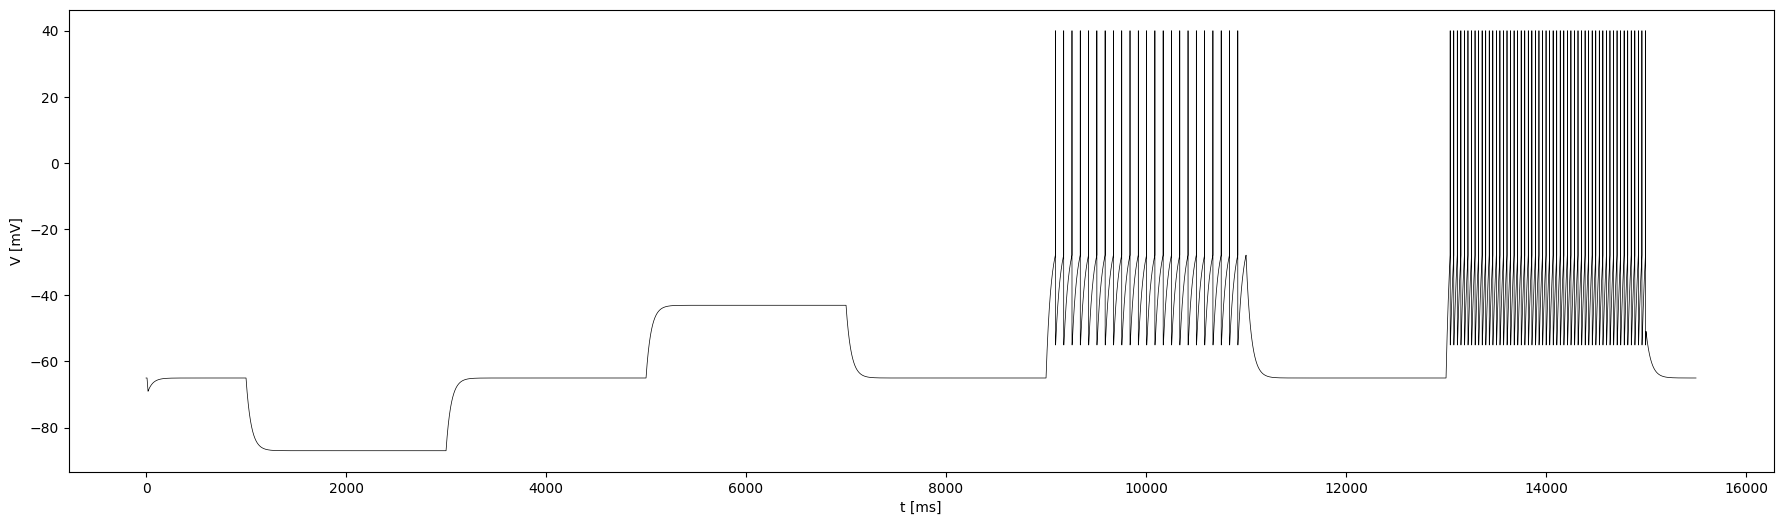

In [27]:
with open('pars_fit_juanba.json') as file:
    lif_kwargs = json.load(file)

lif = LIF_model(**lif_kwargs)
lif.simulate_trajectory(t, I_train, plot=True);

In [34]:
lif.fit_spikes(t,
              spike_times,
              I_train,
              n_per_bin=len(t)//8,
              tweak_keys=['tau_m', 'g_L', 'V_th'],
              tweak_units=[ms, nS, mV],
              N_iter=100,
              max_rep=7,
              pop_size=50,
              mut_rate=0.1,
              mut_scale = 5)

Generation 0: Best Fitness = 7.6336e-03 Params: [54.241448, 12.119166, -24.963882]
Generation 1: Best Fitness = 7.7519e-03 Params: [54.559852, 11.781439, -23.550196]
Generation 2: Best Fitness = 7.7519e-03 Params: [54.559852, 11.781439, -23.550196]
Generation 3: Best Fitness = 7.7519e-03 Params: [54.559852, 11.781439, -23.550196]
Generation 4: Best Fitness = 7.7519e-03 Params: [54.559852, 11.781439, -23.550196]
Generation 5: Best Fitness = 7.7519e-03 Params: [54.559852, 11.781439, -23.550196]
Generation 6: Best Fitness = 7.7519e-03 Params: [54.559852, 11.781439, -23.550196]
Generation 7: Best Fitness = 7.7519e-03 Params: [54.559852, 11.781439, -23.550196]
Generation 8: Best Fitness = 7.7519e-03 Params: [54.559852, 11.781439, -23.550196]
No more evolution


Podemos observar claramente como LIF falla para el primer tren de disparos y a medida que pasa el tiempo se ajusta mejor a la realidad, por otro lado comparamos las tasas de disparos y hallamos lo mismo, para valores iniciales falla pero para los ultimos valores ajusta bien.

Sin embargo, notese que adapta mejor las magnitudes que adex, respetando tanto la altura de los picos como los valores post reset. Siendo este un enorme punto a favor de LIF frente a AdEx, se pone en juego lo que uno busca precision en la magnitud o precision en los eventos.

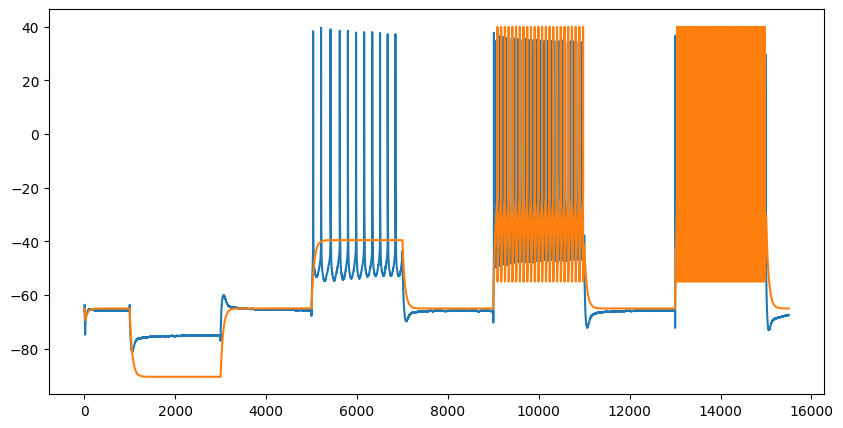

In [35]:
fit_v_lif, spikes_LIF_2 = lif.simulate_trajectory(t, I_train, plot=False)
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(t/ms, v_train)
ax.plot(t/ms, fit_v_lif/mV)
plt.show()

In [36]:
rates_lif = firing_rate(t, spikes_LIF_2, n_per_bin=len(t)//10)
rates_obj = firing_rate(t, spike_times, n_per_bin=len(t)//10)
np.vstack((rates_lif, rates_obj))

array([[ 0,  0,  0,  0,  0,  3, 19,  2, 25, 28],
       [ 0,  0,  0,  7,  4,  6, 25,  2, 25, 24]])

Aun asi, al momento de simular el tiempo restante observamos que ya no se obtiene esa señal ruidosa que representaba el valor medido sino que es una señal mas controlada que representa de manera mas clara los tiempos de disparos de neuronas. Que es lo que ocurre aca? si observamos la señal medida es en su mayoria ruido que se encuentra por debajo de los -60mV, es decir son señales que debido a su magnitud no deberian de provocar el disparo de una neurona sin embargo el ruido de la señal hace que se supere el valor threshold para una pequeña cantidad de valores y que termine disparando. Creemos que estos disparos son los que representa LIF y que debido a su periodo refractario la señal deja de ser tan ruidosa. Por lo tanto, LIF podria estar representando de manera correcta los disparos de las neuronas durante la corriente de test. 

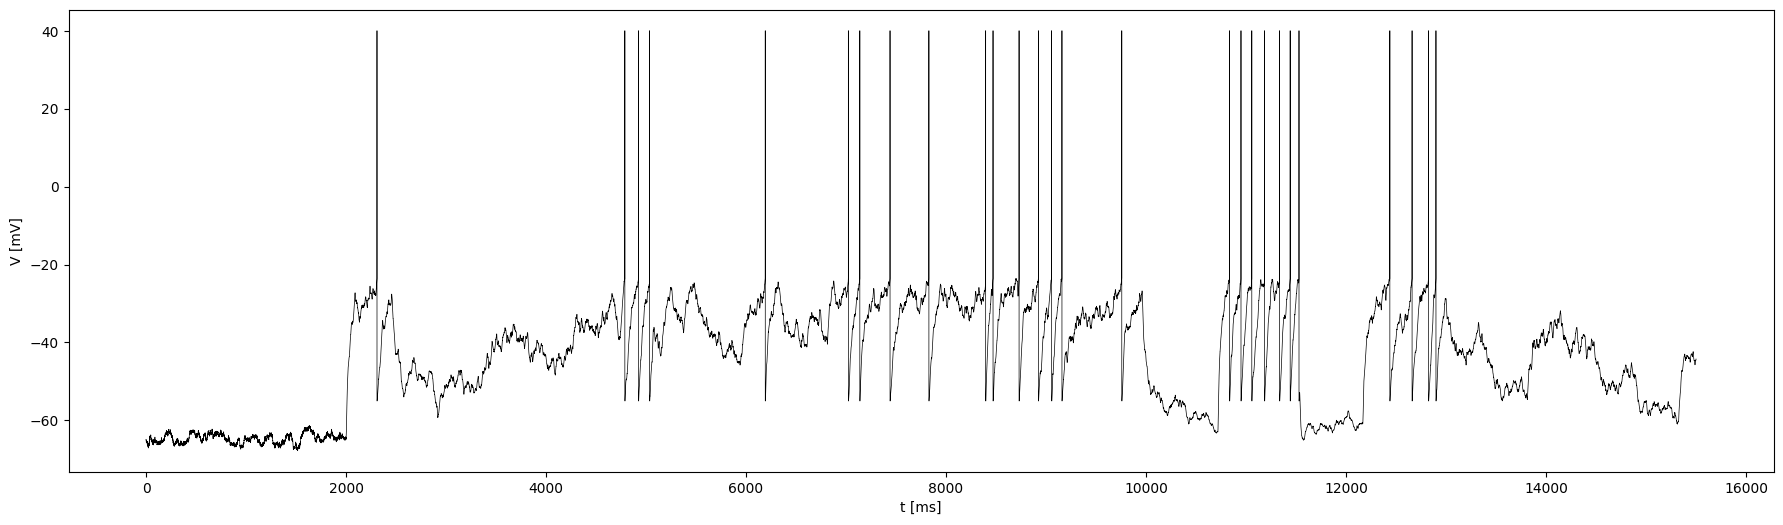

In [39]:

y,z = lif.simulate_trajectory(t, I_test, plot=True);

Comparando las tazas de disparo podemos observar como LIF logra aproximarse bastante a las tasas de disparo medidas en el experimento por lo que LIF podria hasta ser un modelo mas optimo para AdEx

In [43]:
spike_times_medidos_test, test_peaks_h = find_peaks(v_test, height=0)
rates_lif = firing_rate(t, z, n_per_bin=len(t)//10)
rates_obj = firing_rate(t, spike_times_medidos_test, n_per_bin=len(t)//10)
np.vstack((rates_adex, rates_obj))

array([[ 9, 17, 20, 23, 22, 25, 19, 19, 19, 16],
       [ 0,  9, 11, 20, 21, 23, 13, 16, 14,  6]])